In [190]:
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

In [1]:
# dates: 13-15 Sept 2020 inclusive

# Where was Polarstern on these dates?

In [132]:
td = Dataset('/home/robbie/Dropbox/rain_on_snow/ice_type_nh_polstere-100_multi_202009141200.nc')
td_lons = td['lon']
td_lats = td['lat']
td_type = td['ice_type']

In [32]:
d = Dataset('/home/robbie/Dropbox/rain_on_snow/CS_OFFL_SIR_SAR_1B_20200914T091341_20200914T092149_D001.nc')
d

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    product_name: CS_OFFL_SIR_SAR_1B_20200914T091341_20200914T092149_D001
    processing_stage: OFFL
    reference_document: CS-RS-ACS-ESL-5364 1.8 
    doi: 10.5270/CR2-2cnblvi
    acquisition_station: Kiruna              
    mission: Cryosat
    processing_centre: PDS
    creation_time: UTC=2020-10-13T07:38:11
    sensing_start: 14-SEP-2020 09:13:40.716599
    sensing_stop: 14-SEP-2020 09:21:48.699104
    software_version: SIR1SAR/5.6   
    phase: 4
    cycle_number: 18
    rel_orbit_number: 12381
    abs_orbit_number: 55318
    state_vector_time: UTC=2020-09-14T09:17:44.412958
    delta_ut1: -0.17564000189304352
    x_position: -1102065.0
    y_position: -172630.796875
    z_position: 7004393.5
    x_velocity: -7396.74658203125
    y_velocity: 630.7335815429688
    z_velocity: -1146.4813232421875
    vector_source: doris_precise
    leap_utc:                            
    leap_sign: 0
    leap_

In [33]:
d['lat_20_ku'][0]

83.7706905

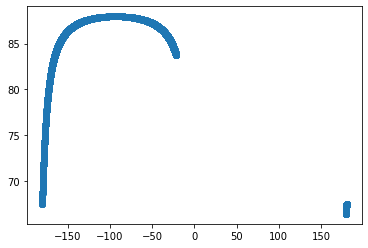

In [34]:
plt.scatter(np.array(d['lon_20_ku']), np.array(d['lat_20_ku']))

In [38]:
import cartopy.crs as ccrs
import cartopy

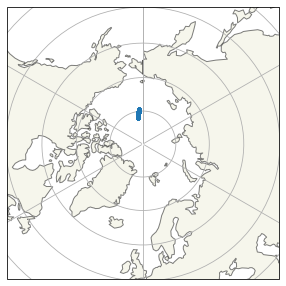

In [52]:
cartoplot_scatter(np.array(d['lon_20_ku'])[5000:6000], np.array(d['lat_20_ku'])[5000:6000], bounding_lat=50)

In [48]:
d['pwr_waveform_20_ku'].shape

(10713, 256)

In [60]:
pw = 2

ar = np.array([1,2,4,5])

ar = np.pad(ar,pad_width=pw)[:ar.shape[0]]

ar

array([0, 0, 1, 2])

In [67]:
import matplotlib.animation as animation
from IPython import display

In [225]:
%matplotlib widget

fig, axs = plt.subplots(1,2,figsize=(10,5))

ax1 = axs[0]


axs[1].remove()
ax2 = fig.add_subplot(1, 2, 2, projection=ccrs.NorthPolarStereo())
ax2.set_extent([-180, 180, 90, 69], ccrs.PlateCarree()) 
ax2.add_feature(cartopy.feature.LAND, edgecolor='black',zorder=1)

ax2.pcolormesh(td_lons,td_lats,td_type[0][:-1,:-1],transform=ccrs.PlateCarree(),
               cmap='gray',vmax=3,vmin=0,alpha=0.1)

segment_start = 0
segment_end = d['lon_20_ku'].shape[0]-700
segment_skip = 100



### AX2

lon_subset = np.array(d['lon_20_ku'])[segment_start:segment_end:segment_skip]
lat_subset = np.array(d['lat_20_ku'])[segment_start:segment_end:segment_skip]
pp_subset = np.array(d['stack_peakiness_20_ku'])[segment_start:segment_end:segment_skip]

subset = np.column_stack((lon_subset, lat_subset))

scat = ax2.scatter(lon_subset[0],
                        lat_subset[1],
                        s=1,color='k',
                        transform=ccrs.PlateCarree())

### AX1

ax1.set_ylim(0,80_000)
ax1.set_xlim(120,250)

subset_data = d['pwr_waveform_20_ku'][segment_start:segment_end:segment_skip]

l, = ax1.plot(np.zeros(256),color='r',alpha=1,zorder=1,lw=2)
    
def animate(frame):
    
    new_data = subset[:frame]
    
    scat.set_offsets(new_data)
    
    ar = subset_data[frame]
    
    ind_max = np.argmax(ar)
    
    pw = 150 - ind_max

    ar = np.pad(ar,pad_width=pw)[:ar.shape[0]]
    
    ax1.plot(ar,color='k',alpha=0.25,zorder=0,lw=0.5)
    
    l.set_ydata(ar)
    
ax1.set_yticks([])
ax1.set_xticks([])
ax1.set_ylabel('Returned Power',fontsize='x-large')
ax1.set_xlabel('Range/Time',fontsize='x-large')


ani = animation.FuncAnimation(fig,
                              animate,
                             frames= range(1,
#                                            3,
                                           subset_data.shape[0],
                                          ),
                             )    

plt.subplots_adjust(wspace=0.01)


video = ani.to_html5_video()
html = display.HTML(video)
display.display(html)
plt.close()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

CalledProcessError: Command '['ffmpeg', '-f', 'rawvideo', '-vcodec', 'rawvideo', '-s', '1000x500', '-pix_fmt', 'rgba', '-r', '5.0', '-loglevel', 'error', '-i', 'pipe:', '-vcodec', 'h264', '-pix_fmt', 'yuv420p', '-y', '/tmp/tmpjtdxvp8h/temp.m4v']' returned non-zero exit status 255.

In [154]:
subset_data.shape

(101, 256)

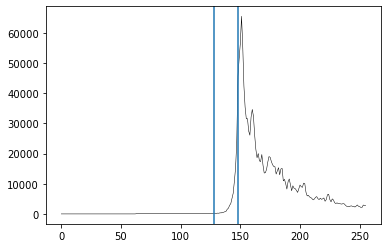

In [227]:
%matplotlib inline

fig, ax = plt.subplots(1,1)

for frame in [50]:
    
    ar = subset_data[frame]
    
    ind_max = np.argmax(ar)
    
    
    pw = 150 - ind_max

    ar = np.pad(ar,pad_width=pw)[:ar.shape[0]]

    ind_hp = np.argmax(ar>np.max(ar)/2)
    
    ax.plot(ar,color='k',alpha=1,zorder=0,lw=0.5)
    
    ax.axvline(ind_hp)
    
    ax.axvline(ind_hp-20)
    
    exponential_obs = ar[ind_hp-20 : ind_hp]

plt.show()

In [186]:
def func(x, a, c):
    return a*np.exp(-c*x)

/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


(0.0, 2.0)

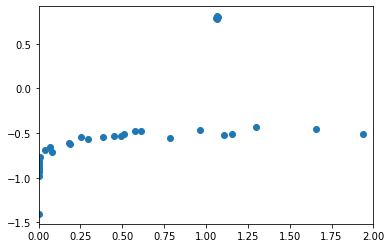

In [217]:

a_list, b_list = [], []

for frame in np.arange(subset_data.shape[0]):
    
    ar = subset_data[frame]

    ind_hp = np.argmax(ar>np.max(ar)/2)
    
    exponential_obs = ar[ind_hp-20 : ind_hp]

    x = np.arange(exponential_obs.shape[0])
    y = exponential_obs

    # plt.plot(x,np.log(y))

    popt, pcov = curve_fit(func, x, y)
    
    a, b = popt
    
    a_list.append(a)
    b_list.append(b)

    y_fit = func(x, *popt)

#     plt.plot(exponential_obs)
#     plt.plot(x, y_fit)
#     plt.show()



plt.scatter(a_list,b_list)
plt.xlim(0,2.0)

# fit
# plt.plot(x, fit[1] * np.exp(fit[0]*x))

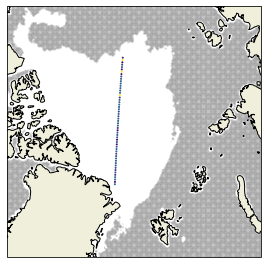

In [238]:
fig, ax1 = plt.subplots(1,1,figsize=(10,5))

ax1.remove()
ax1 = fig.add_subplot(1, 2, 2, projection=ccrs.NorthPolarStereo())
ax1.set_extent([-180, 180, 90, 75], ccrs.PlateCarree()) 
ax1.add_feature(cartopy.feature.LAND, edgecolor='black',zorder=1)

ax1.pcolormesh(td_lons,td_lats,td_type[0][:-1,:-1],transform=ccrs.PlateCarree(),
               cmap='gray',vmax=3,vmin=0,alpha=0.1)


ax1.scatter(lon_subset[:55],
            lat_subset[:55],
            c=b_list[:55],
            s=1,
            transform=ccrs.PlateCarree())


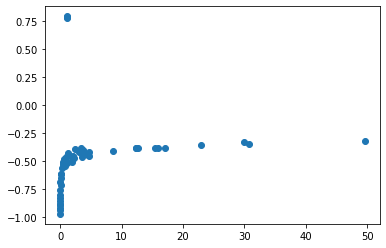

In [242]:
plt.scatter(a_list[:55],np.array(b_list)[:55])
# plt.ylim(-10,50)

In [224]:
for var in d.variables:
    print(var)

agc_ch1_20_ku
agc_ch2_20_ku
alt_20_ku
alt_avg_01_ku
beam_dir_vec_20_ku
cor2_applied_20_ku
dop_angle_start_20_ku
dop_angle_stop_20_ku
dop_cor_20_ku
echo_numval_20_ku
echo_numval_avg_01_ku
echo_scale_factor_20_ku
echo_scale_factor_avg_01_ku
echo_scale_pwr_20_ku
echo_scale_pwr_avg_01_ku
flag_echo_20_ku
flag_echo_avg_01_ku
flag_instr_conf_rx_bwdt_20_ku
flag_instr_conf_rx_flags_20_ku
flag_instr_conf_rx_in_use_20_ku
flag_instr_conf_rx_str_in_use_20_ku
flag_instr_conf_rx_trk_mode_20_ku
flag_instr_mode_att_ctrl_20_ku
flag_instr_mode_flags_20_ku
flag_instr_mode_op_20_ku
flag_mcd_20_ku
flag_trk_cycle_20_ku
h0_applied_20_ku
h0_fai_word_20_ku
h0_lai_word_20_ku
instr_cor_gain_rx_20_ku
instr_cor_gain_tx_rx_20_ku
instr_cor_range_rx_20_ku
instr_cor_range_tx_rx_20_ku
instr_ext_ph_cor_20_ku
instr_int_ph_cor_20_ku
inter_base_vec_20_ku
lat_20_ku
lat_avg_01_ku
lon_20_ku
lon_avg_01_ku
look_angle_start_20_ku
look_angle_stop_20_ku
noise_power_20_ku
off_nadir_pitch_angle_str_20_ku
off_nadir_roll_angle_str_20_k

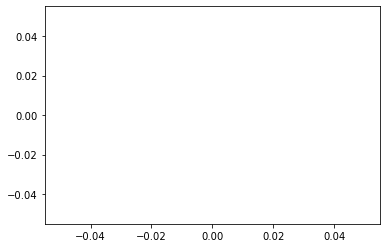

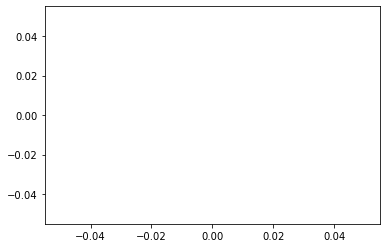

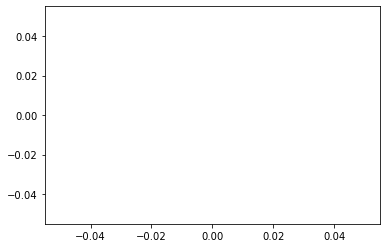

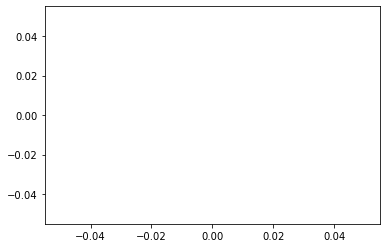

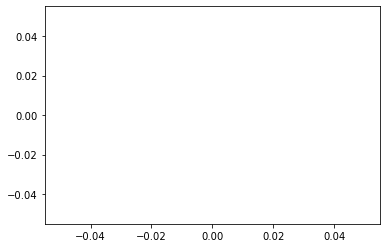

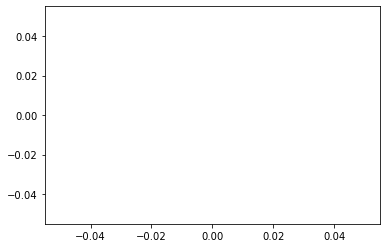

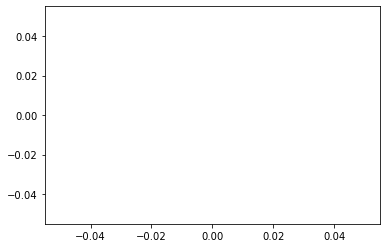

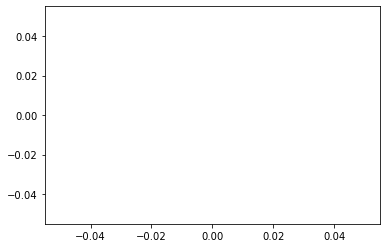

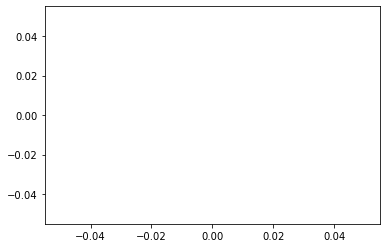

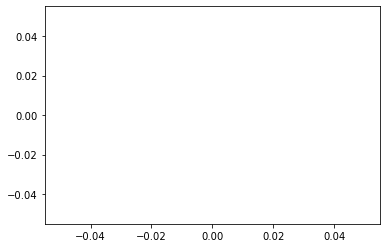

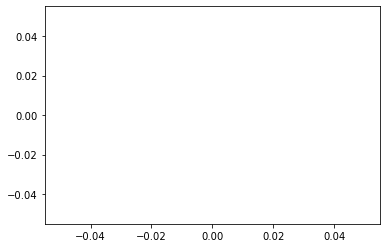

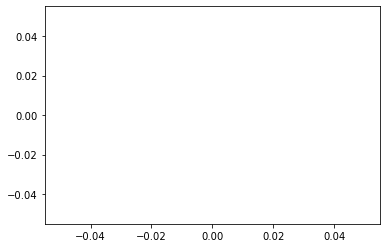

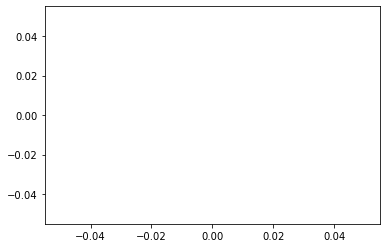

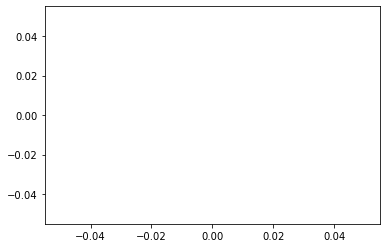

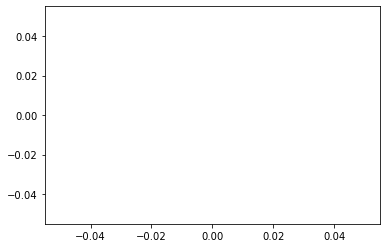

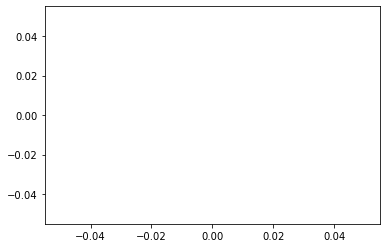

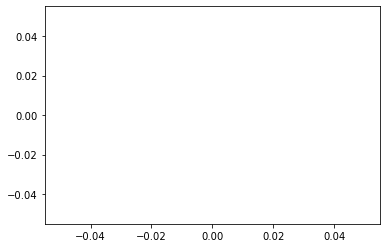

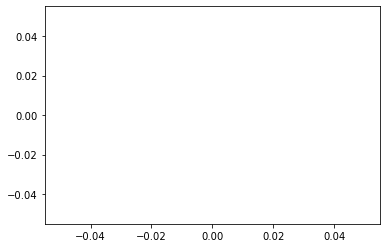

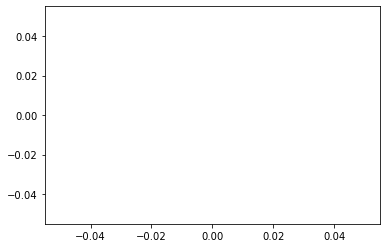

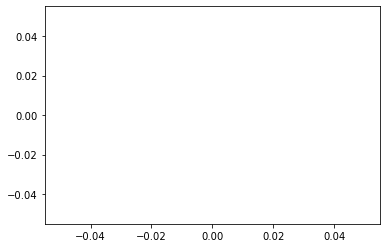

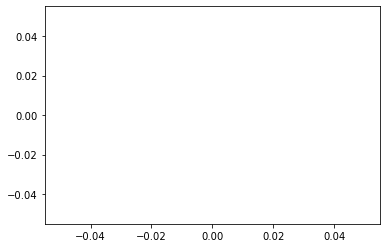

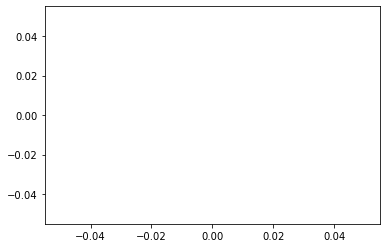

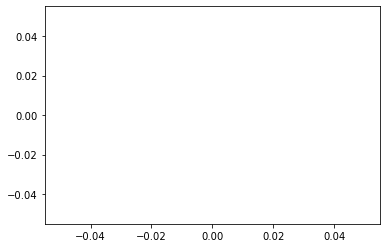

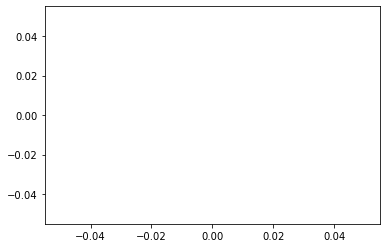

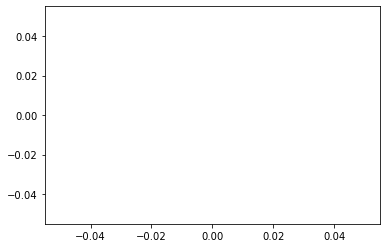

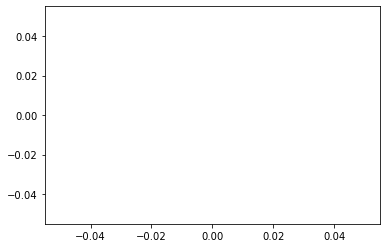

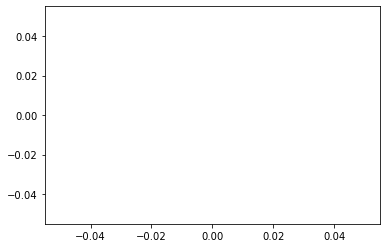

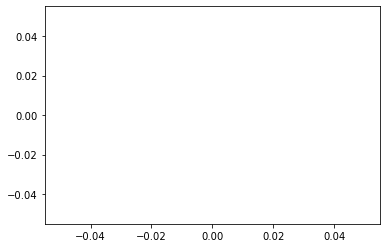

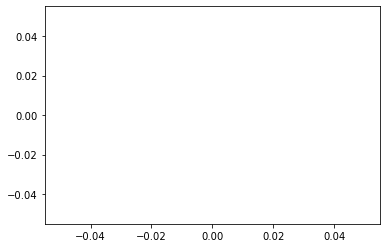

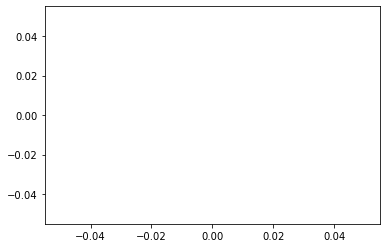

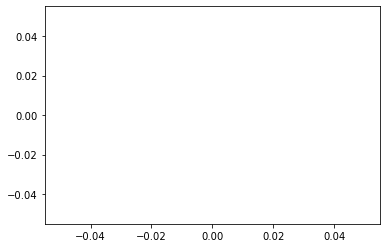

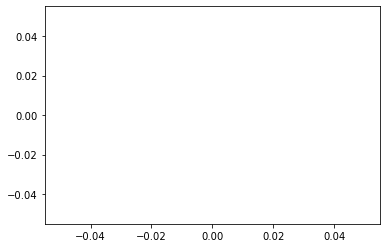

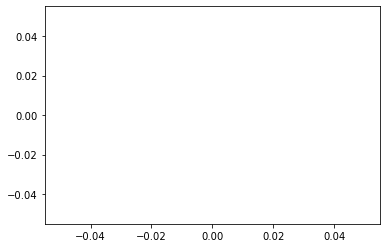

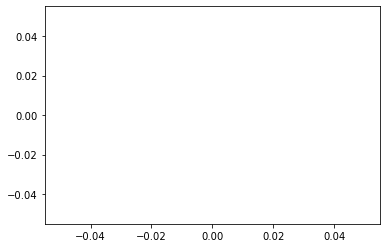

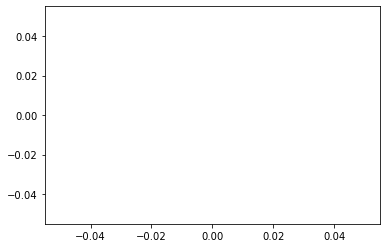

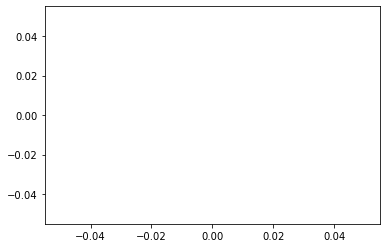

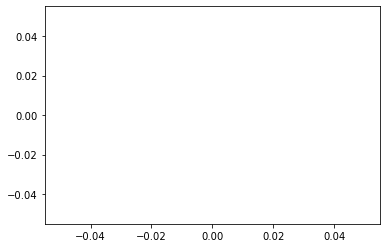

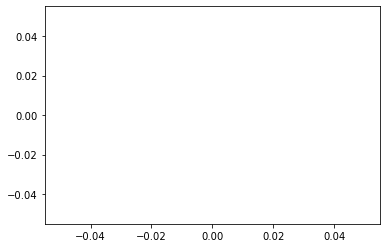

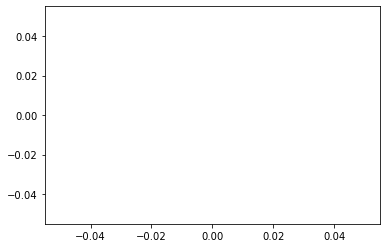

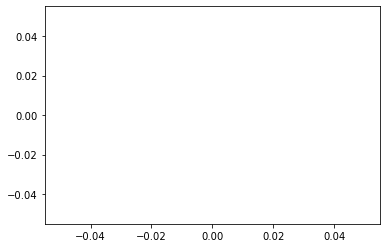

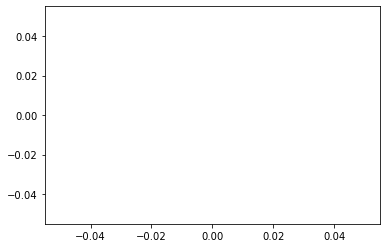

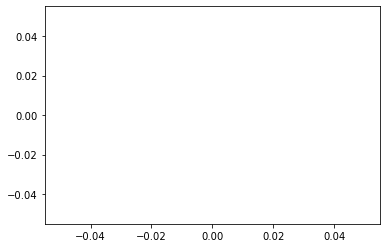

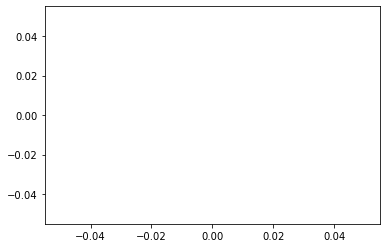

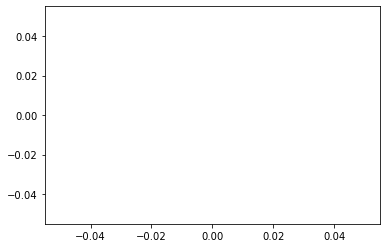

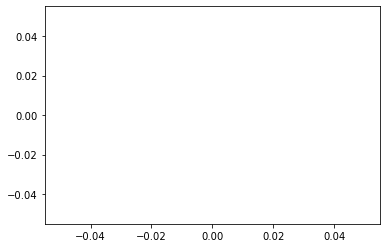

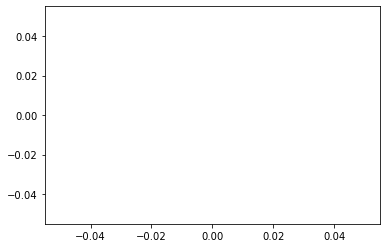

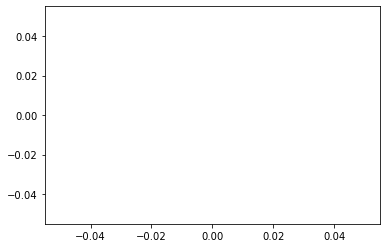

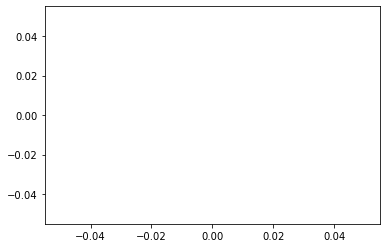

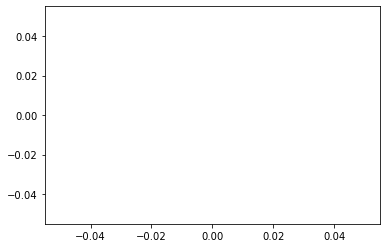

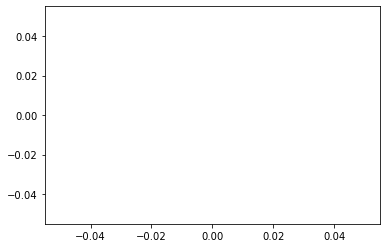

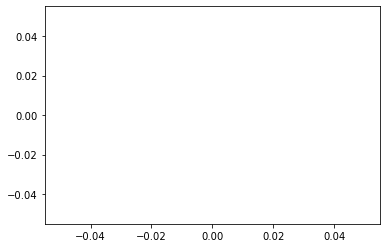

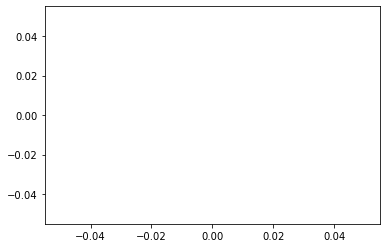

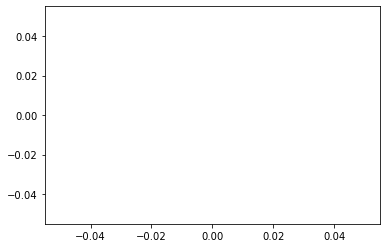

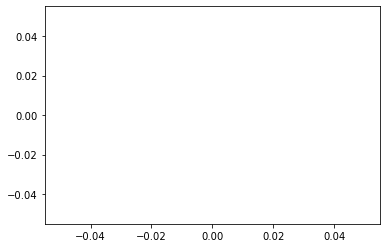

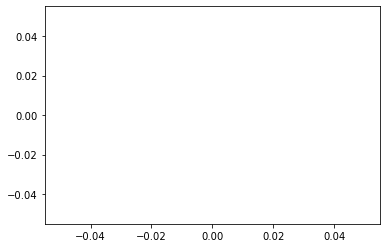

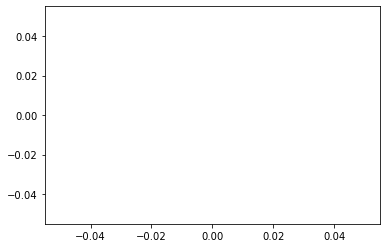

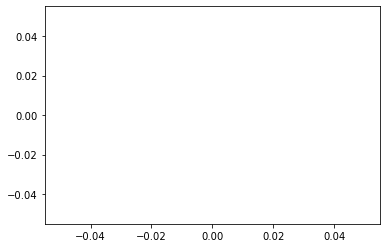

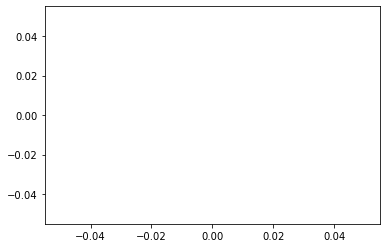

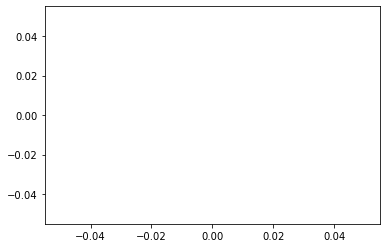

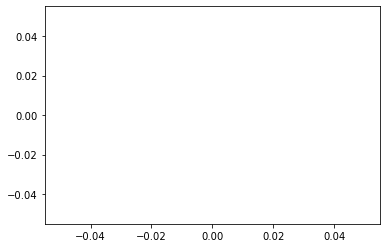

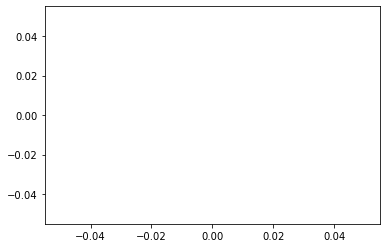

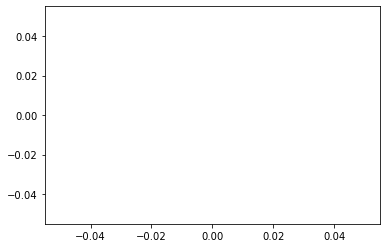

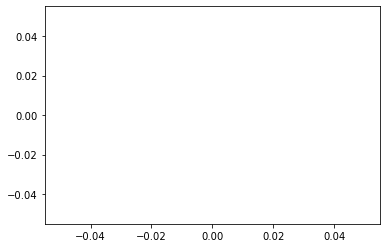

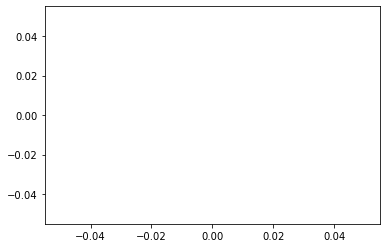

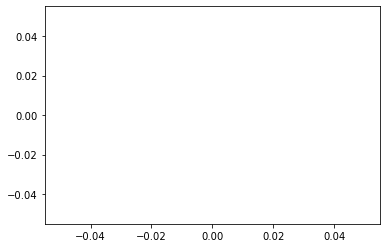

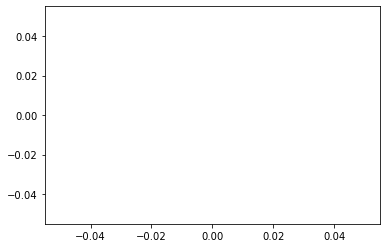

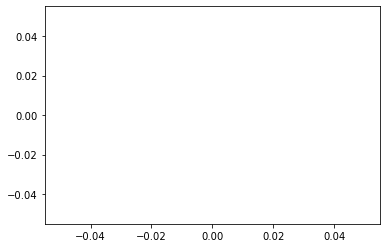

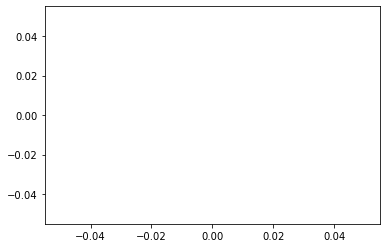

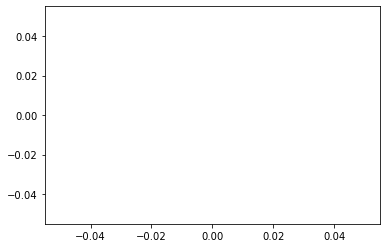

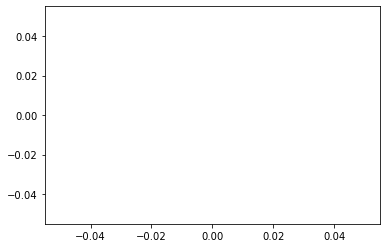

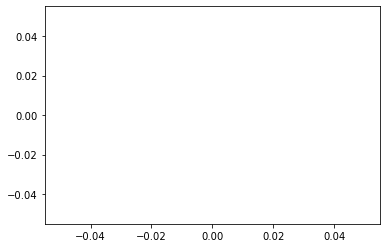

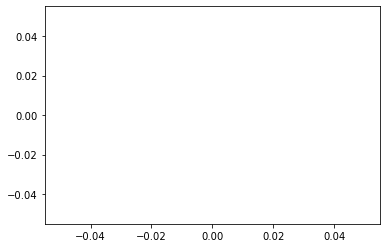

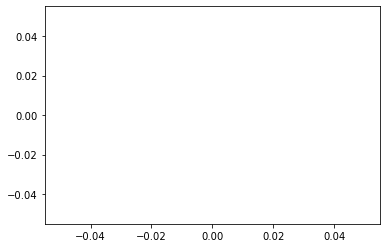

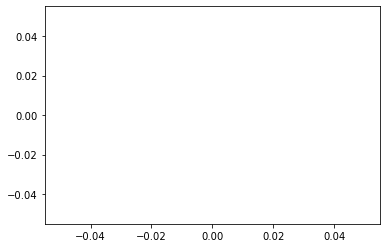

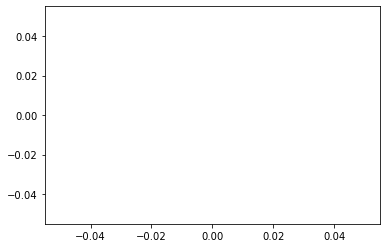

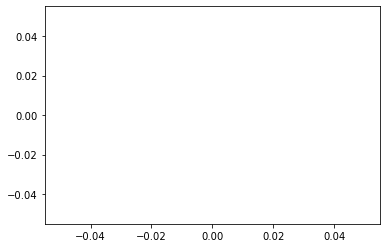

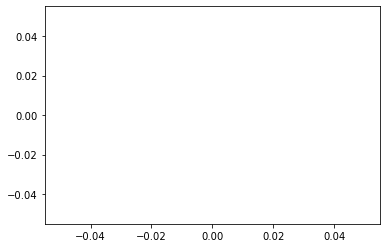

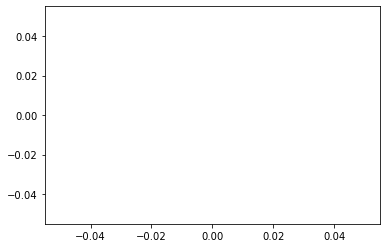

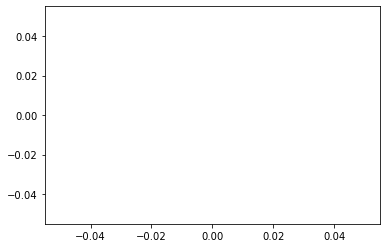

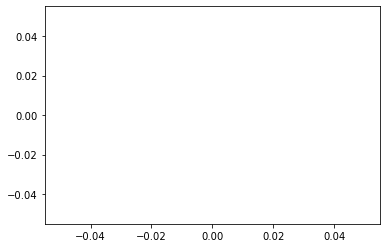

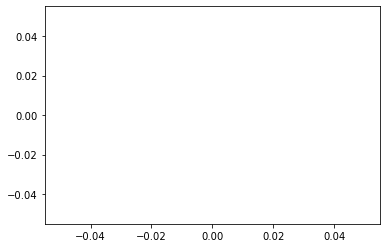

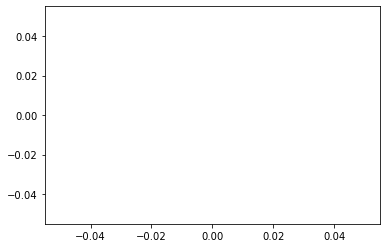

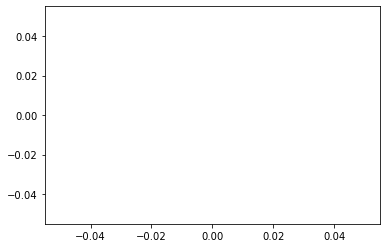

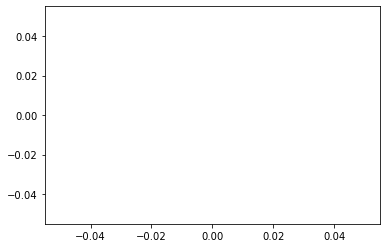

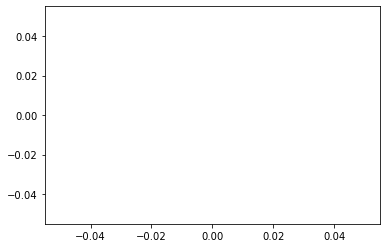

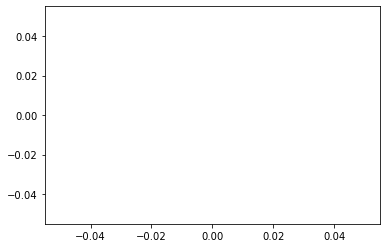

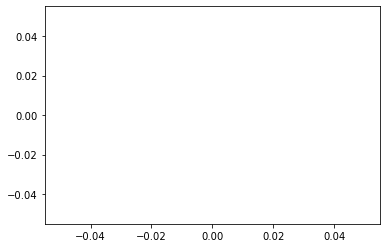

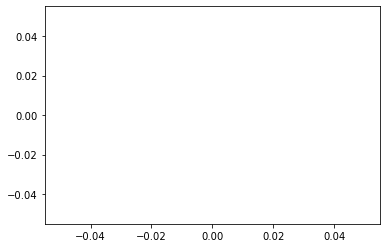

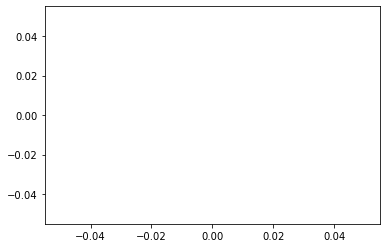

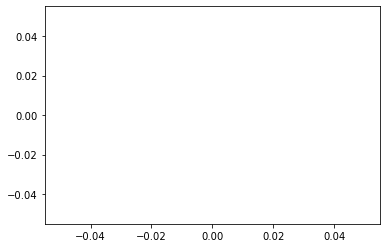

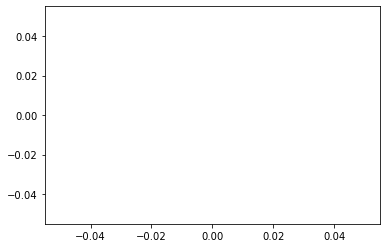

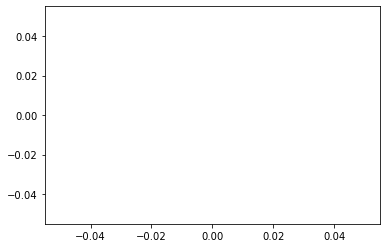

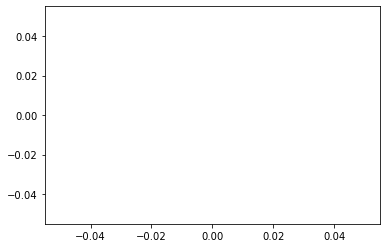

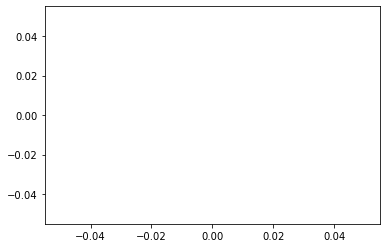

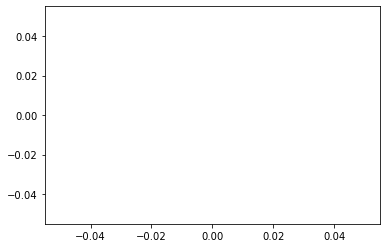

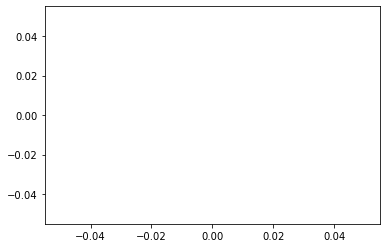

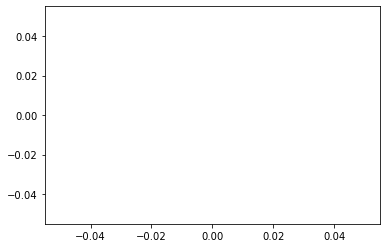

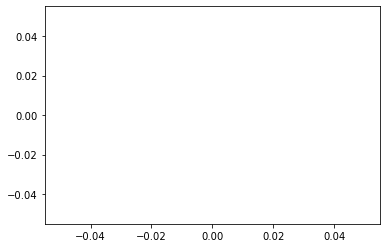

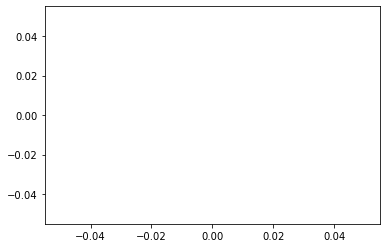

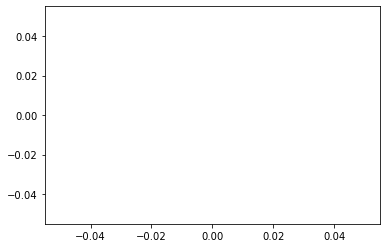

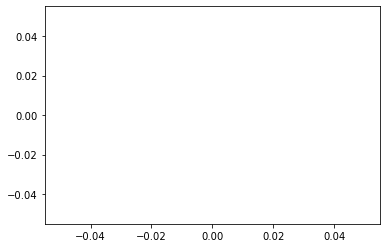

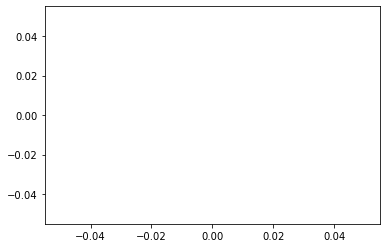

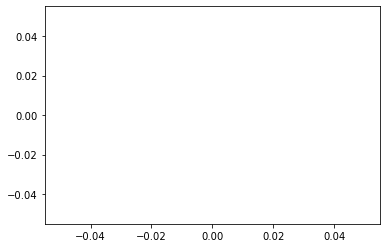

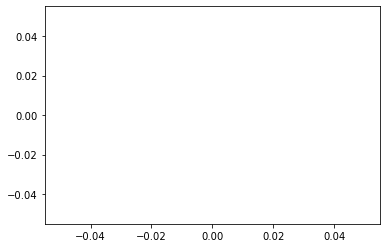

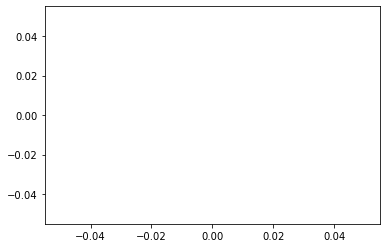

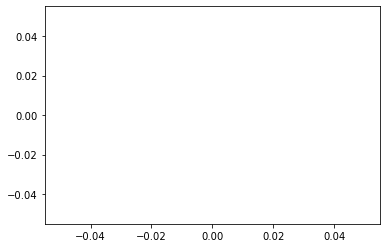

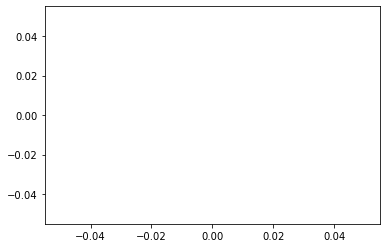

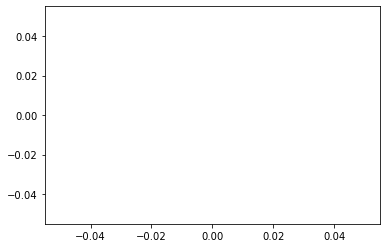

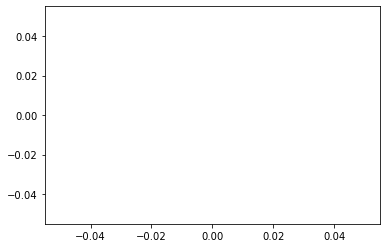

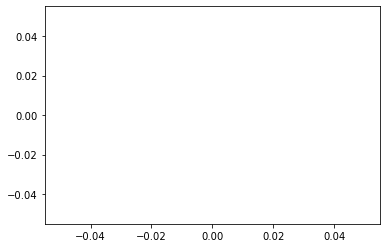

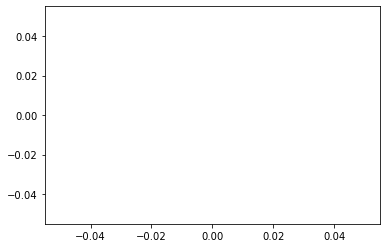

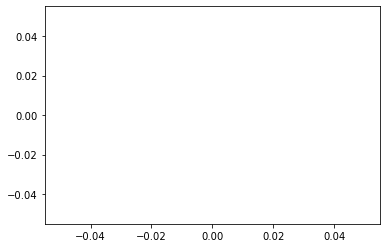

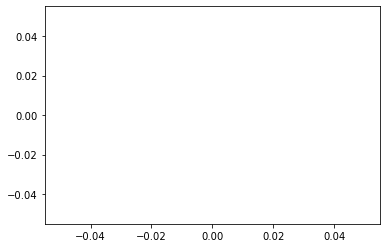

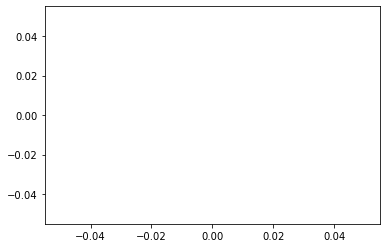

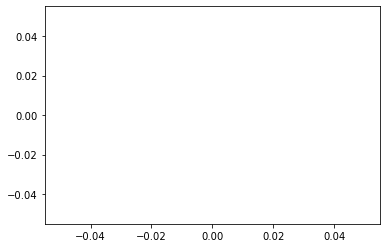

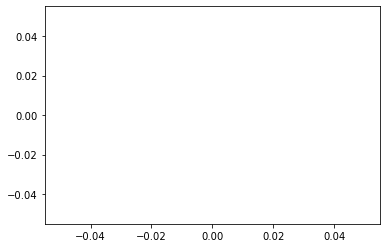

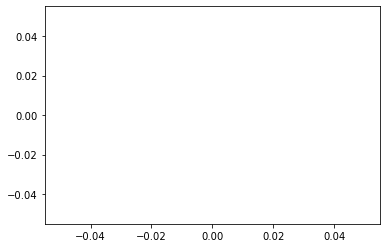

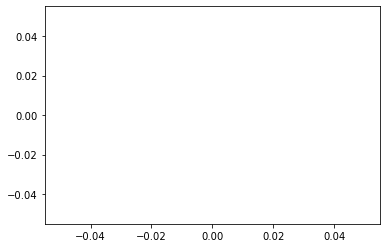

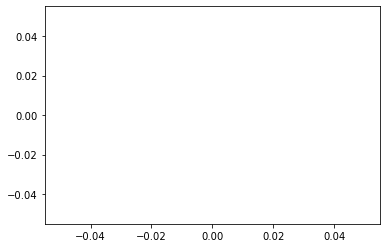

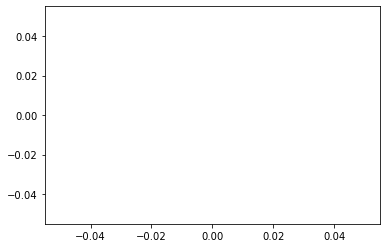

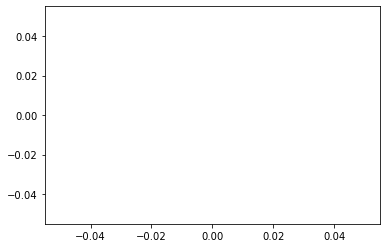

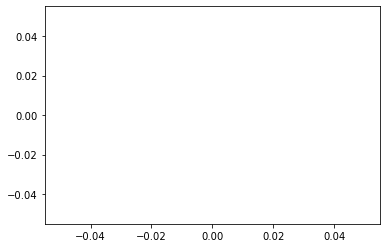

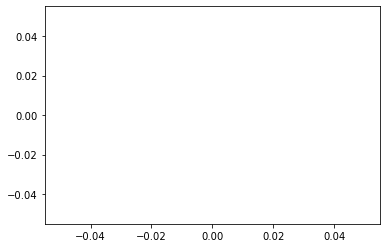

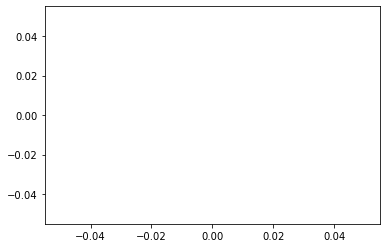

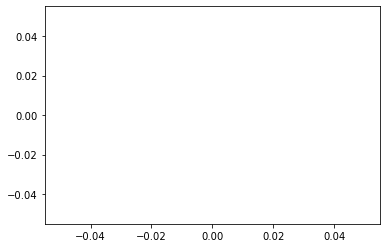

In [21]:
for i in d['coherence_waveform_20_ku']:
    plt.plot(i)
    plt.show()

agc_ch1_20_ku


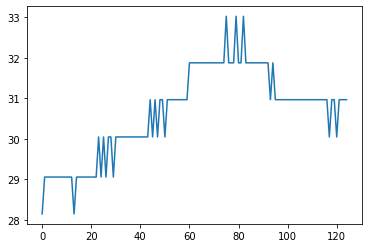

agc_ch2_20_ku


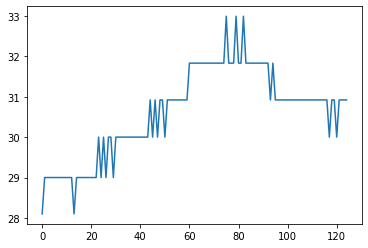

alt_20_ku


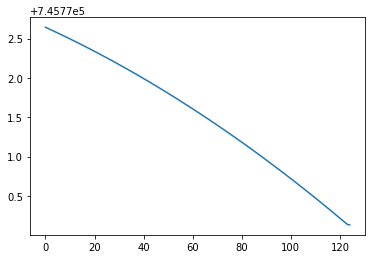

alt_avg_01_ku


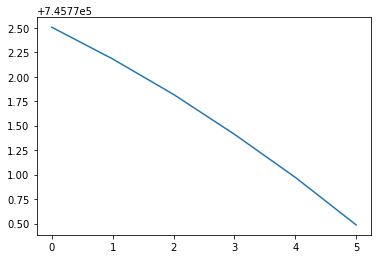

beam_dir_vec_20_ku


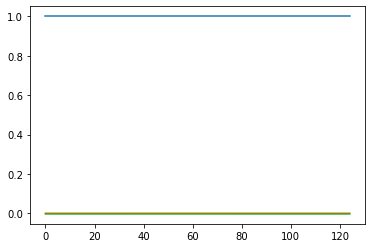

cor2_applied_20_ku


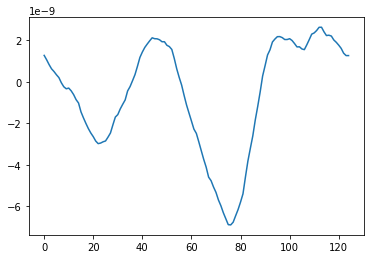

dop_angle_start_20_ku


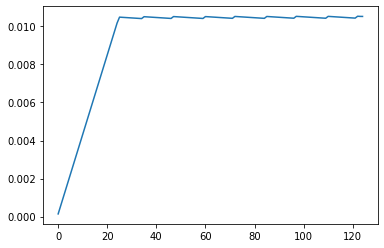

dop_angle_stop_20_ku


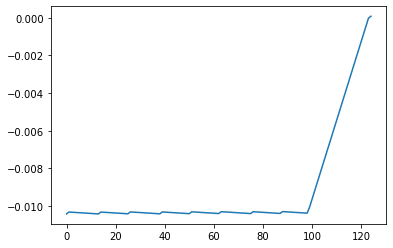

dop_cor_20_ku


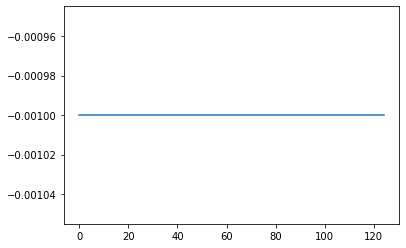

echo_numval_20_ku


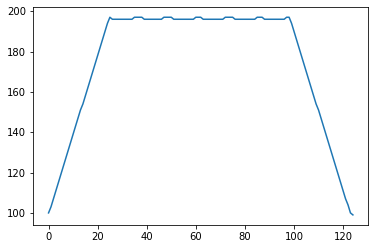

echo_numval_avg_01_ku


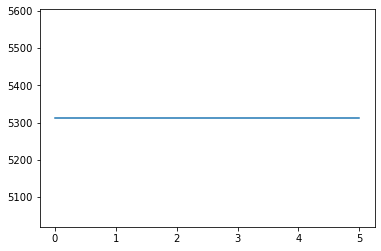

echo_scale_factor_20_ku


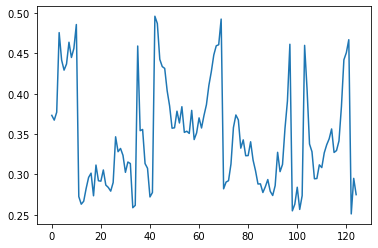

echo_scale_factor_avg_01_ku


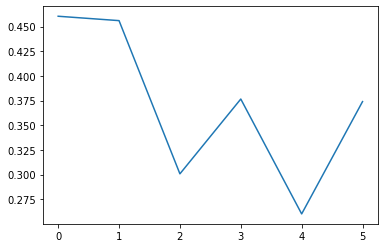

echo_scale_pwr_20_ku


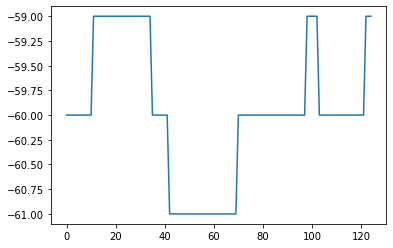

echo_scale_pwr_avg_01_ku


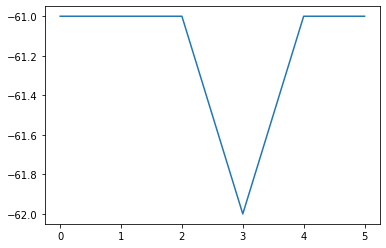

flag_echo_20_ku


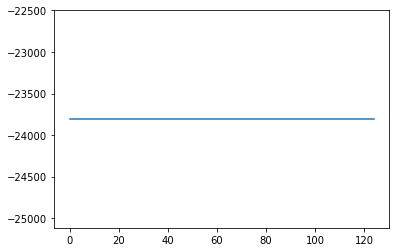

flag_echo_avg_01_ku


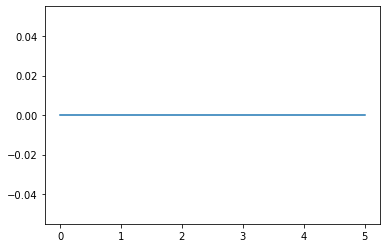

flag_instr_conf_rx_bwdt_20_ku


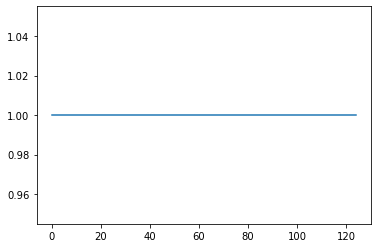

flag_instr_conf_rx_flags_20_ku


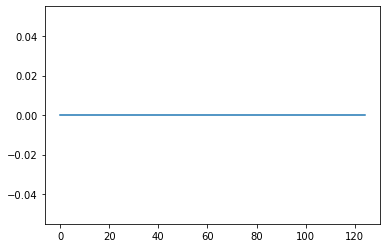

flag_instr_conf_rx_in_use_20_ku


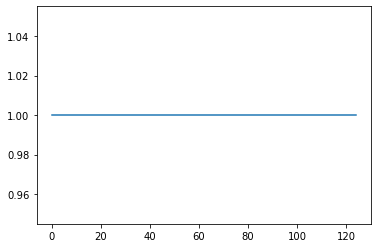

flag_instr_conf_rx_str_in_use_20_ku


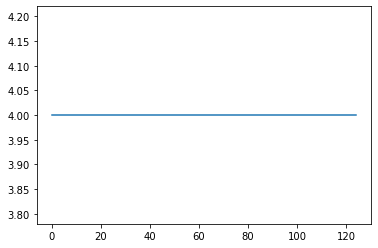

flag_instr_conf_rx_trk_mode_20_ku


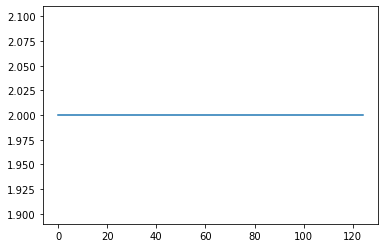

flag_instr_mode_att_ctrl_20_ku


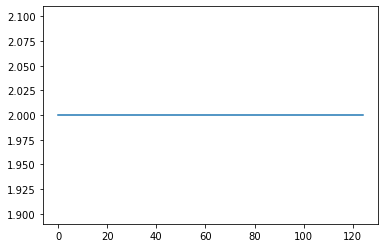

flag_instr_mode_flags_20_ku


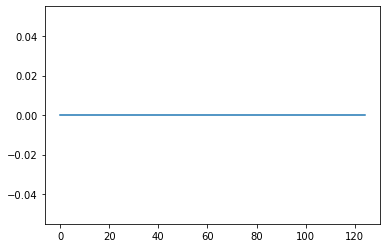

flag_instr_mode_op_20_ku


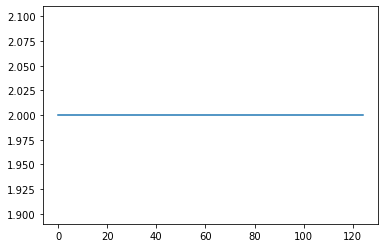

flag_mcd_20_ku


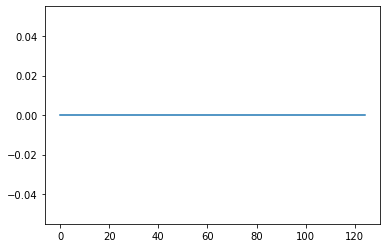

flag_trk_cycle_20_ku


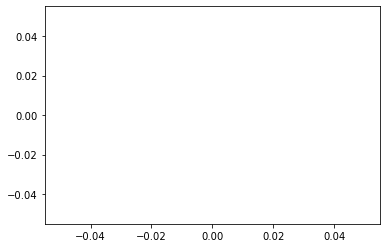

h0_applied_20_ku


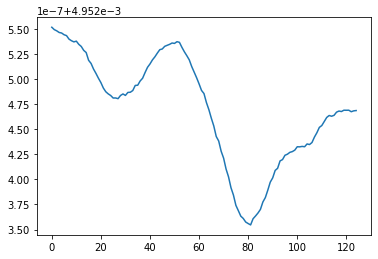

h0_fai_word_20_ku


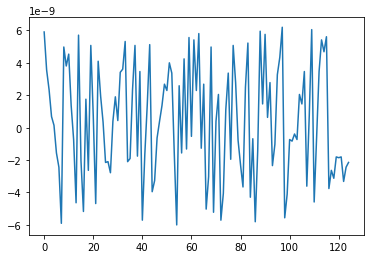

h0_lai_word_20_ku


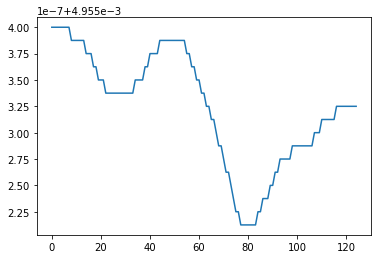

instr_cor_gain_rx_20_ku


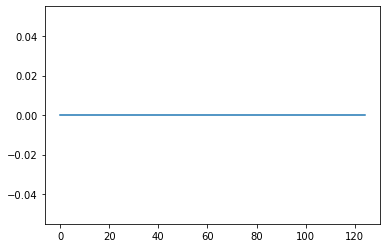

instr_cor_gain_tx_rx_20_ku


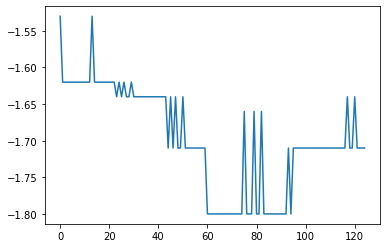

instr_cor_range_rx_20_ku


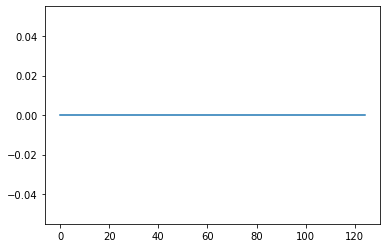

instr_cor_range_tx_rx_20_ku


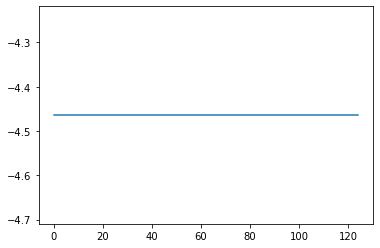

instr_ext_ph_cor_20_ku


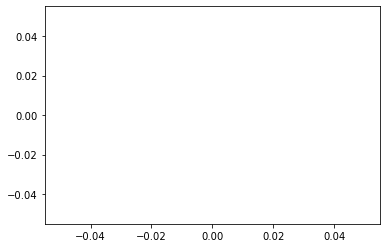

instr_int_ph_cor_20_ku


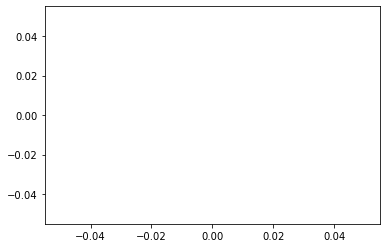

inter_base_vec_20_ku


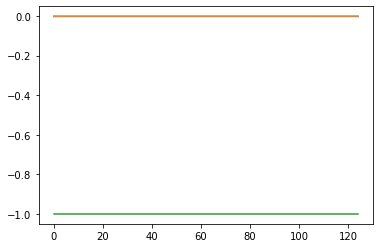

lat_20_ku


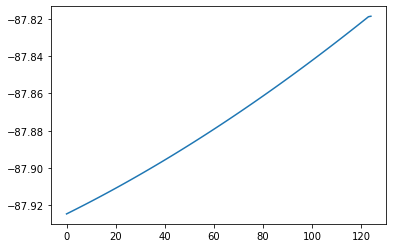

lat_avg_01_ku


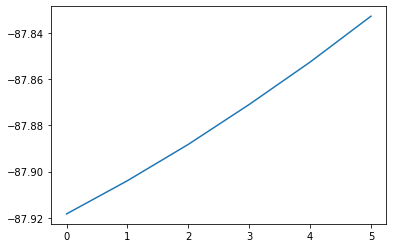

lon_20_ku


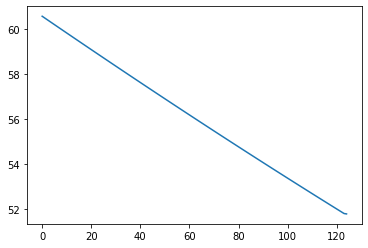

lon_avg_01_ku


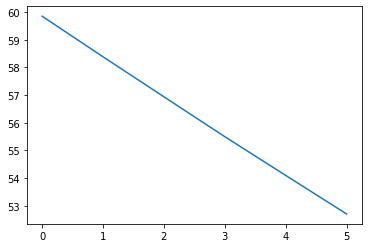

look_angle_start_20_ku


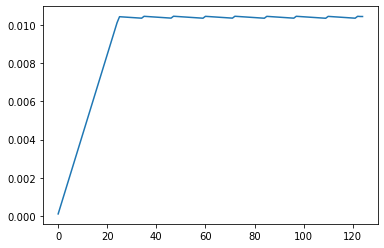

look_angle_stop_20_ku


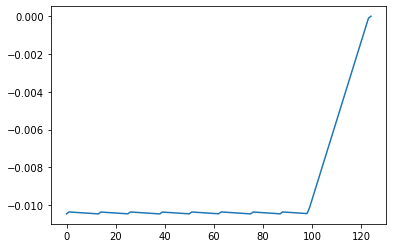

noise_power_20_ku


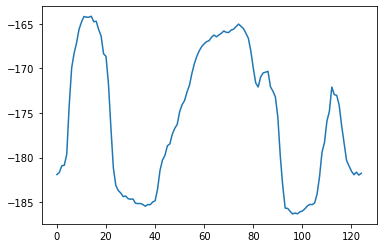

off_nadir_pitch_angle_str_20_ku


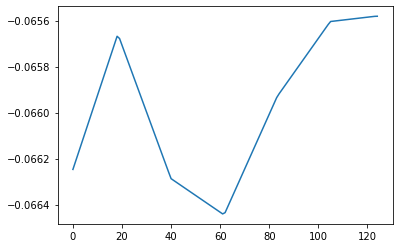

off_nadir_roll_angle_str_20_ku


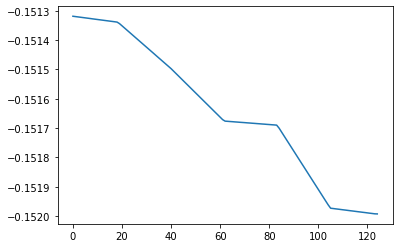

off_nadir_yaw_angle_str_20_ku


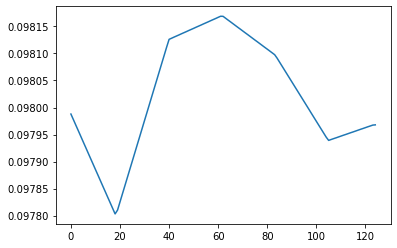

orb_alt_rate_20_ku


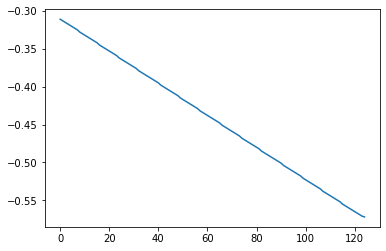

ph_slope_cor_20_ku


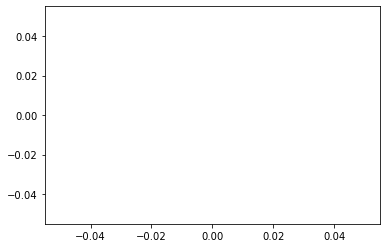

pwr_waveform_20_ku


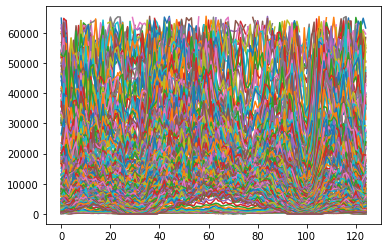

pwr_waveform_avg_01_ku


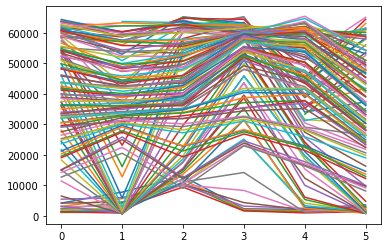

rec_count_20_ku


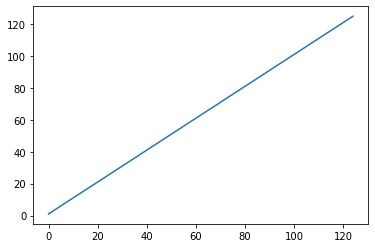

sat_vel_vec_20_ku


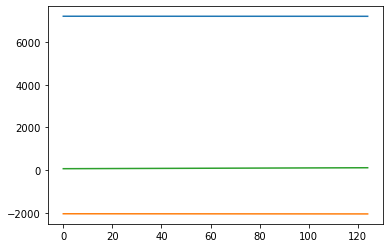

seq_count_20_ku


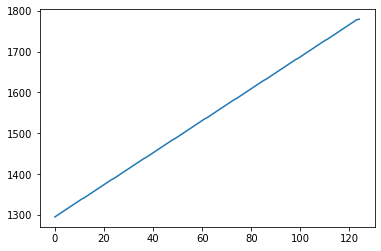

stack_centre_20_ku


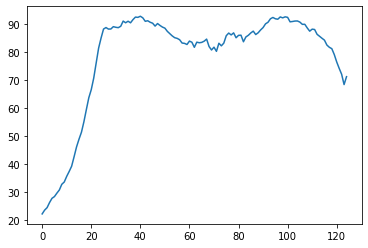

stack_centre_angle_20_ku


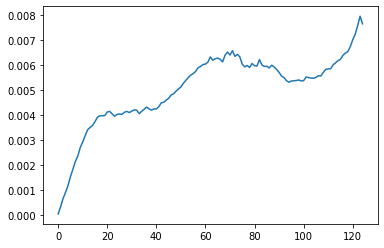

stack_centre_look_angle_20_ku


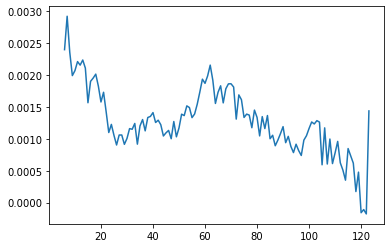

stack_gaussian_fitting_residuals_20_ku


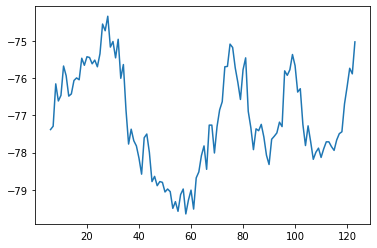

stack_kurtosis_20_ku


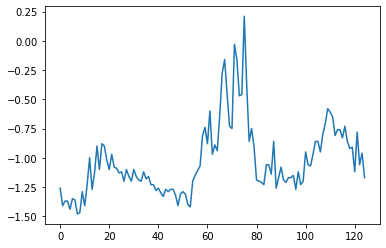

stack_number_after_weighting_20_ku


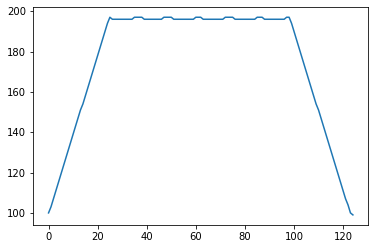

stack_number_before_weighting_20_ku


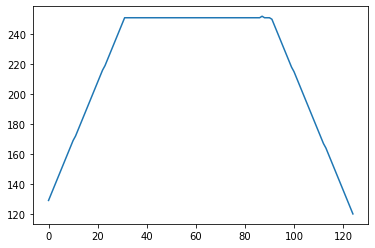

stack_peakiness_20_ku


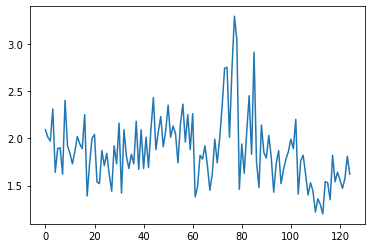

stack_scaled_amplitude_20_ku


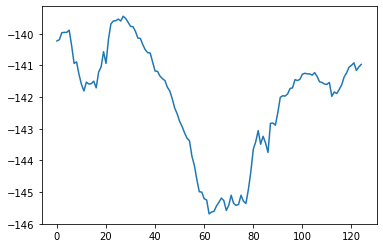

stack_skewness_20_ku


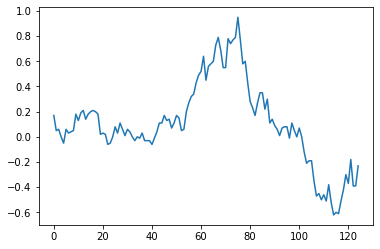

stack_std_20_ku


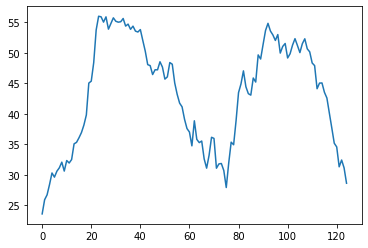

stack_std_angle_20_ku


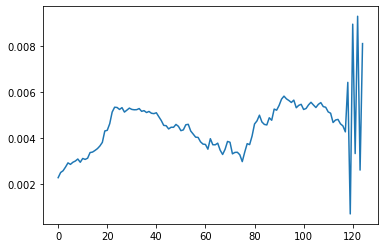

time_20_ku


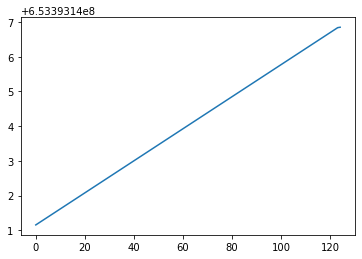

time_avg_01_ku


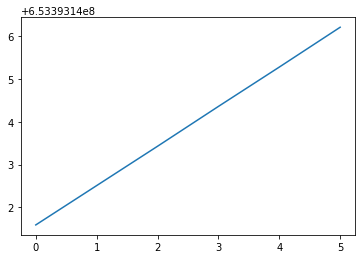

tot_gain_ch1_20_ku


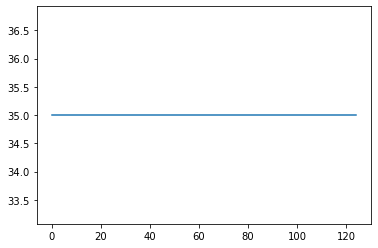

tot_gain_ch2_20_ku


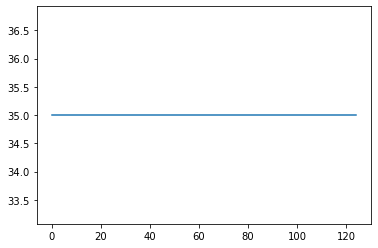

transmit_pwr_20_ku


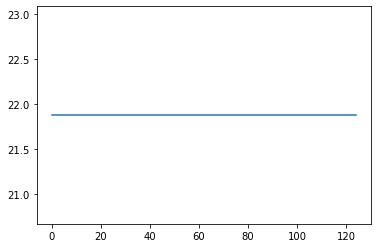

uso_cor_20_ku


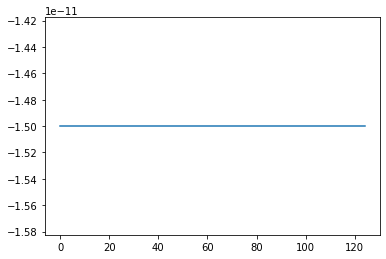

uso_cor_avg_01_ku


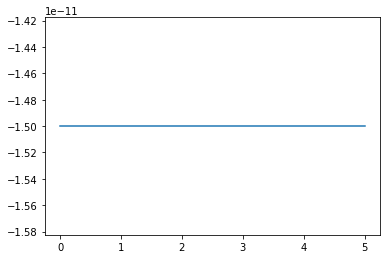

window_del_20_ku


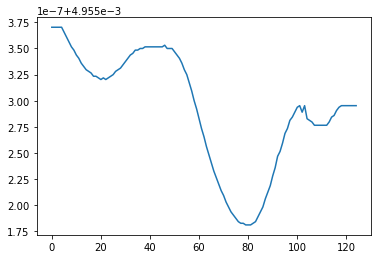

window_del_avg_01_ku


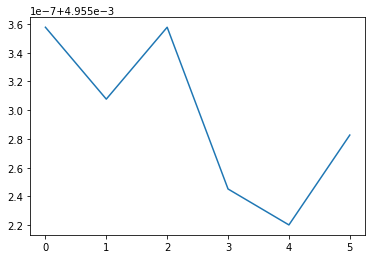

time_cor_01


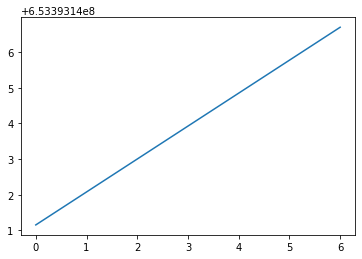

mod_dry_tropo_cor_01


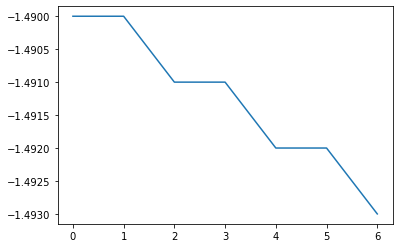

mod_wet_tropo_cor_01


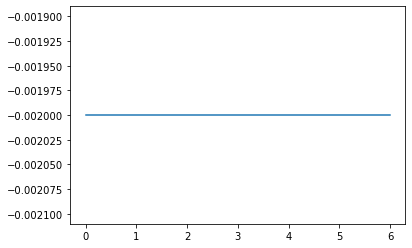

inv_bar_cor_01


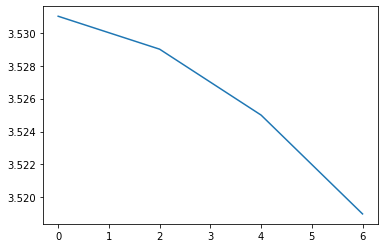

hf_fluct_total_cor_01


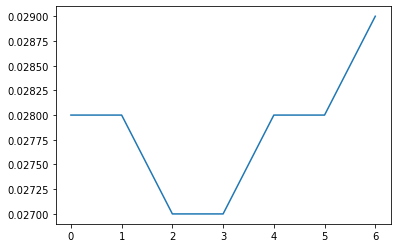

iono_cor_gim_01


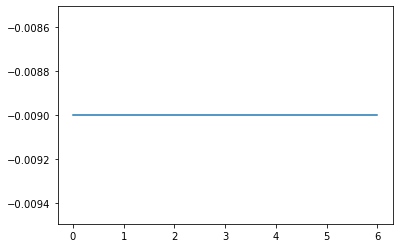

iono_cor_01


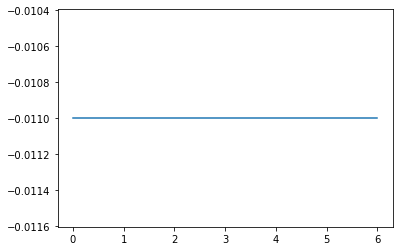

ocean_tide_01


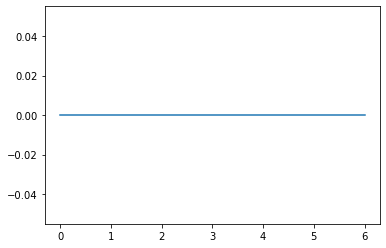

ocean_tide_eq_01


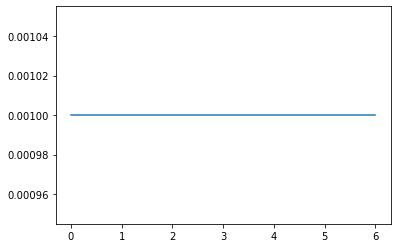

load_tide_01


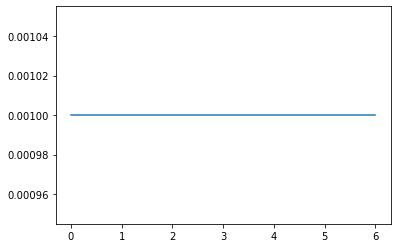

solid_earth_tide_01


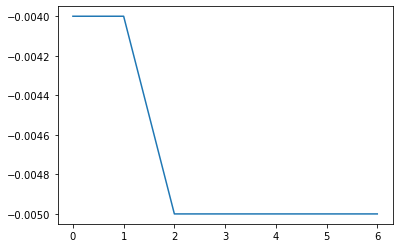

pole_tide_01


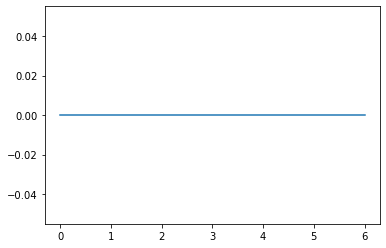

surf_type_01


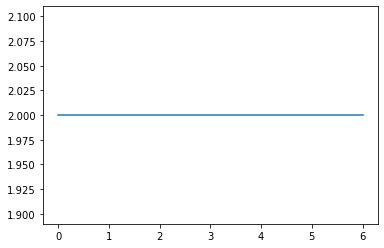

flag_cor_status_01


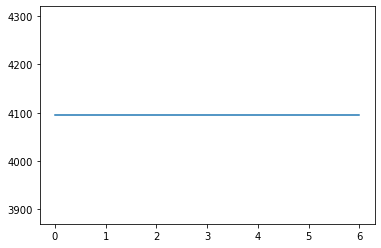

flag_cor_err_01


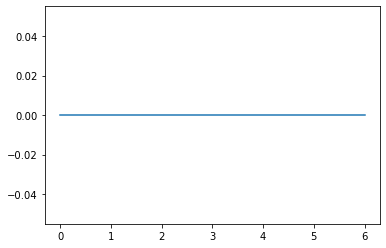

ind_first_meas_20hz_01


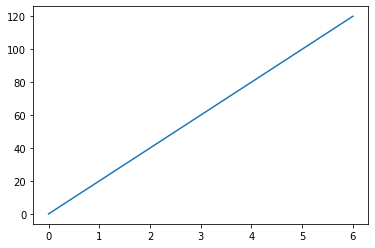

ind_meas_1hz_20_ku


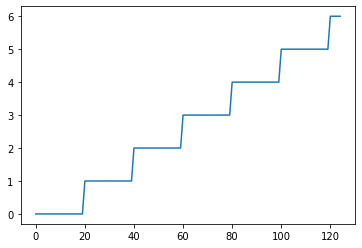

coherence_waveform_20_ku


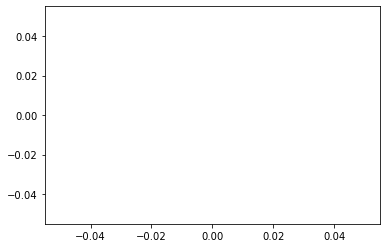

ph_diff_waveform_20_ku


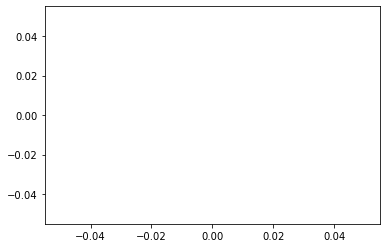

In [15]:
for variable in d.variables:
    print(variable)
    plt.plot(d[variable])
    plt.show()

In [12]:
np.array(d['freeboard_20_ku'])

array([-32768., -32768., -32768., -32768., -32768., -32768., -32768.,
       -32768., -32768., -32768., -32768., -32768., -32768., -32768.,
       -32768., -32768., -32768., -32768., -32768., -32768., -32768.,
       -32768., -32768., -32768., -32768., -32768., -32768., -32768.,
       -32768., -32768., -32768., -32768., -32768., -32768., -32768.,
       -32768., -32768., -32768., -32768., -32768., -32768., -32768.,
       -32768., -32768., -32768., -32768., -32768., -32768., -32768.,
       -32768., -32768., -32768., -32768., -32768., -32768., -32768.,
       -32768., -32768., -32768., -32768., -32768., -32768., -32768.,
       -32768., -32768., -32768., -32768., -32768., -32768., -32768.,
       -32768., -32768., -32768., -32768., -32768., -32768., -32768.,
       -32768., -32768., -32768., -32768., -32768., -32768., -32768.,
       -32768., -32768., -32768., -32768., -32768., -32768., -32768.,
       -32768., -32768., -32768., -32768., -32768., -32768., -32768.,
       -32768., -327